In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

In [2]:
#np.save('interp_1d_wavelength.npy', INTERPOLATED_WAVELENGTH)
#np.save('interp_1d_spectra.npy', INTERPOLATED_SPECTRA)

In [15]:
FLUX = np.load('interp_1d_spectra.npy', allow_pickle=True)
WAVELENGTH = np.load('interp_1d_wavelength.npy', allow_pickle=True)

In [16]:
FLUX.shape, WAVELENGTH.shape

((56, 26, 12774), (56, 26, 12774))

In [17]:
from pylab import *
colormap='Greys'

cmap = cm.get_cmap(colormap, 60)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

cmap = cm.get_cmap('viridis', 60)
vcolors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    vcolors.append(matplotlib.colors.rgb2hex(rgb))
vcolors = np.array(vcolors)

In [18]:
from astropy.time import Time
times = np.load('mjddates.npy', allow_pickle=True)
times
conv_time = Time(times, format='mjd').jd
conv_time

array([2458870.725, 2458870.73 , 2458870.734, 2458870.739, 2458870.744,
       2458870.748, 2458870.753, 2458870.758, 2458870.762, 2458870.767,
       2458870.778, 2458870.782, 2458870.787, 2458870.791, 2458870.796,
       2458870.801, 2458870.805, 2458870.81 , 2458870.815, 2458870.819,
       2458870.824, 2458870.829, 2458870.833, 2458870.838, 2458870.843,
       2458870.847, 2458870.852, 2458870.857, 2458870.861, 2458870.866,
       2458870.871, 2458870.875, 2458870.88 , 2458870.885, 2458870.889,
       2458870.894, 2458870.899, 2458870.903, 2458870.908, 2458870.913,
       2458870.917, 2458870.922, 2458870.927, 2458870.931, 2458870.936,
       2458870.941, 2458870.945, 2458870.95 , 2458870.955, 2458870.959,
       2458870.964, 2458870.969, 2458870.973, 2458871.05 , 2458871.052,
       2458871.053])

In [19]:
planet_d_per = 12.403200
planet_c_per = 8.249580

planet_c_t0 = 2458846.097156
planet_d_t0 = 2458845.803649

c_happen = np.where( ((planet_c_t0 + np.arange(1,14,1)*planet_c_per) >= conv_time[0]) & 
                     ((planet_c_t0 + np.arange(1,14,1)*planet_c_per) <= conv_time[-1]) )[0]
d_happen = np.where( ((planet_d_t0 + np.arange(1,14,1)*planet_d_per) >= conv_time[0]) & 
                     ((planet_d_t0 + np.arange(1,14,1)*planet_d_per) <= conv_time[-1]) )[0]

c_happen, d_happen

(array([2]), array([], dtype=int64))

In [20]:
planet_c_per*3+planet_c_t0

2458870.845896

In [21]:
halpha_order = 11
halpha_vline = 655.62
halpha_wavelength = WAVELENGTH[:,halpha_order,:]

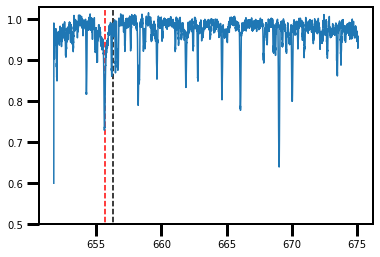

In [22]:
plt.plot(halpha_wavelength[0],
         FLUX[:,halpha_order][0])
plt.vlines(656.3, 0, 2, 'k', linestyle='--')
plt.vlines(655.7, 0, 2, 'r', linestyle='--')
plt.ylim(0.5, 1.03);

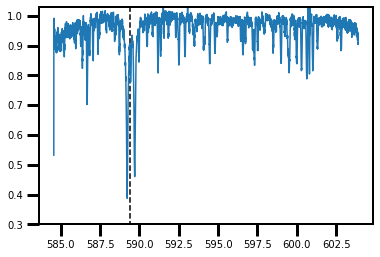

In [23]:
# SODIUM DOUBLET
sodium_order = 15
plt.plot(WAVELENGTH[:,sodium_order][0], 
         FLUX[:,sodium_order][0])
plt.vlines(589.4, 0, 2, 'k', linestyle='--')
plt.ylim(0.3, 1.03);
sodium_vline = 589.4
sodium_wavelength = WAVELENGTH[:,sodium_order,:]

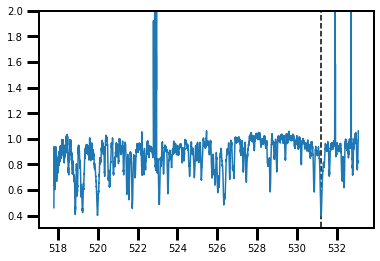

In [24]:
# IRON TRIPEL
iron_order = 20
plt.plot(WAVELENGTH[:,iron_order][0], 
         FLUX[:,iron_order][0])
plt.vlines(531.2, 0, 2, 'k', linestyle='--')
plt.ylim(0.3, 2);
iron_vline = 531.66
iron_wavelength = WAVELENGTH[:,iron_order,:]

## Back to my reduced spectra

In [26]:
template = np.nanmedian(FLUX[-4:-3], axis=(0))
template.shape

(26, 12774)

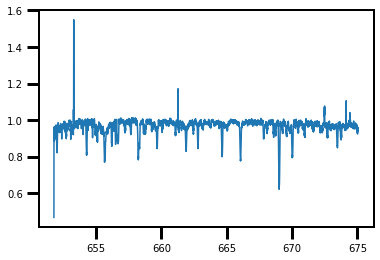

In [27]:
plt.plot(halpha_wavelength[0], template[11])

In [30]:
SPECTRA = FLUX[:,:,:] + 0.0
SPECTRA.shape

(56, 26, 12774)

In [31]:
residuals = np.zeros((len(SPECTRA), SPECTRA.shape[2]))
transmission = np.zeros((len(SPECTRA), SPECTRA.shape[2]))

for i in range(len(SPECTRA)):
    residuals[i] = SPECTRA[i,halpha_order,:] - template[halpha_order]
    transmission[i] = (SPECTRA[i,halpha_order,:] / template[halpha_order]) - 1

In [32]:
transmission.shape

(56, 12774)

In [33]:
# CHUNK 1: start - 0.762 # POTENTIALLY BOTH
# CHUNK 2: 0.764 - 0.941 # PLANET C
# CHUNK 3 : 0.941 - end  # OUT OF TRANSIT 

In [34]:
BIN1 = np.where(conv_time<=2458870.762)[0]
BIN2 = np.where( (conv_time>2458870.762))[0][:-4]
BIN3 = np.arange(0,len(conv_time),1,dtype=int)[np.arange(-4,-3,1,dtype=int)]
print(BIN1, BIN3)

[0 1 2 3 4 5 6 7 8] [52]


In [35]:
def plot_residuals(wavelength_order, order, data, save=False, output_name=None):
    global BIN1, BIN2, BIN3
    
    both_transits  = np.nanmedian(data[BIN1], axis=0)
    transit_c      = np.nanmedian(data[BIN2], axis=0)
    out_of_transit = np.nanmedian(data[BIN3], axis=0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14,10), sharex=True)

    ax1.plot(wavelength_order[0], both_transits[halpha_order], 
             label='Both', c=vcolors[0], lw=2)
    ax1.plot(wavelength_order[0], transit_c[halpha_order], 
             label='Planet c', c=vcolors[15], lw=2)
    ax1.plot(wavelength_order[0], out_of_transit[halpha_order], 
             label='Out of Transit', c=vcolors[25], lw=2)
    ax1.legend(ncol=3, markerscale=5)
    ax1.set_ylabel('Relative Flux')

    ax2.plot(wavelength_order[0], 
             both_transits[order]/out_of_transit[order] - 1, 'k')
    ax2.set_ylabel('$F_{both}/F_{out}$ - 1')
    ax2.set_ylim(-0.1, 0.1)

    ax3.plot(wavelength_order[0], 
             transit_c[order]/out_of_transit[order] - 1, 'k')
    ax3.set_ylabel('$F_{c,in}/F_{out}$ - 1')
    ax3.set_xlabel('Wavelength [nm]')
    ax2.set_xlim(np.min(wavelength_order[0]), np.max(wavelength_order[0]))
    plt.subplots_adjust()
    
    if save is True:
        plt.savefig('/Users/arcticfox/Desktop/{}'.format(output_name), 
                    dpi=250, bbox_inches='tight',
                   rasterize=True)
    else:
        plt.show()

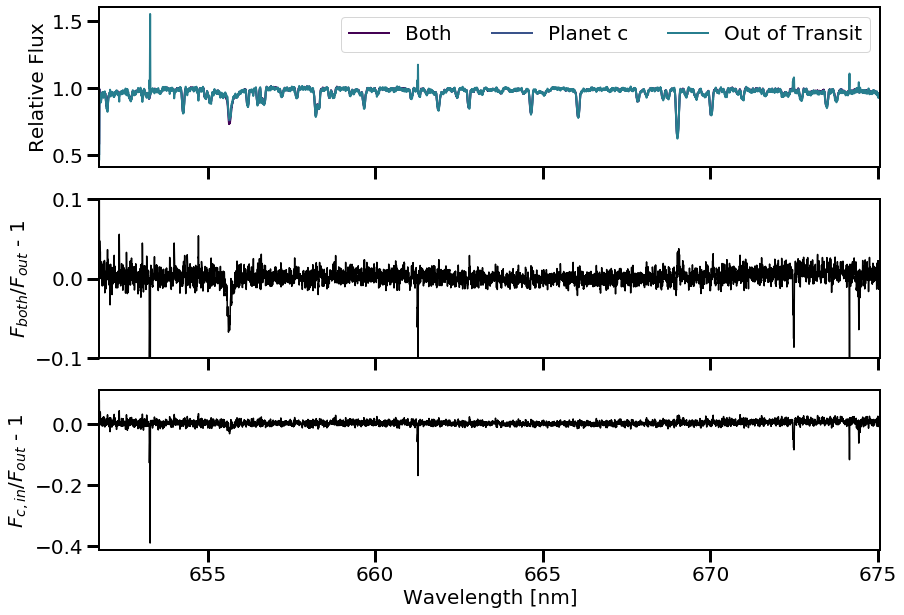

In [38]:
plot_residuals(halpha_wavelength, halpha_order, SPECTRA)

In [37]:
plt.rcParams['font.size'] = 20

In [133]:
BIN3

array([52])

In [105]:
def plot_transmissions(wavelength_order, order, data, subregion,
                       save=False, feature='H-alpha', ax=None, row=1):
    global BIN1, BIN2, BIN3, halpha_wavelength
    
    if feature=='H-alpha':
        restframe = 0.65
    else:
        restframe = 0.28
    
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    else:
        ax1, ax2 = ax[0], ax[1]
    
    both_transits  = data[BIN1,order,subregion[0]:subregion[-1]]
    transit_c      = data[BIN2,order,subregion[0]:subregion[-1]]
    out_of_transit = data[BIN3,order,subregion[0]:subregion[-1]]
    template_out   = np.nanmedian(data[BIN3,order,subregion[0]:subregion[-1]], axis=0)

    
    for i in range(len(both_transits)):
        if i == 1:
            bad_ind = np.where((wavelength_order[0][subregion[0]:subregion[-1]]>655.62) &
                               (wavelength_order[0][subregion[0]:subregion[-1]]<655.65))[0]
            q = np.delete(np.arange(0,len(both_transits[i]),1,dtype=int), bad_ind)
            ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]][q] + restframe, 
                     both_transits[i][q], c=vcolors[5], alpha=0.9)
            ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]][q] + restframe, 
                     both_transits[i][q]+100, c=vcolors[5], alpha=0.9, label='Planets c and d',
                     linewidth=5)
        else:
            q = np.arange(0,len(both_transits[i]),1,dtype=int)
            ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]][q] + restframe, 
                 both_transits[i][q], c=vcolors[5], alpha=0.5)
            
        ax2.plot(i, np.nansum(both_transits[i][q]/template_out[q] - 1) * -1 , 'o', 
                 c=vcolors[5])
        
    for j in range(len(transit_c)):
        if (np.nansum((transit_c[j]/template_out) - 1) < 20 and 
            np.nansum((transit_c[j]/template_out) - 1) > -5):
            ax2.plot(j+i, np.nansum(transit_c[j]/template_out - 1) * -1, 
                     'o')#, c=vcolors[45])

            if j == 0:
                ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]], 
                         transit_c[j]+100, zorder=1, label='Planet c',
                         linewidth=5)#, c=vcolors[45])
                
            ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]]+ restframe, 
                         transit_c[j])#c=vcolors[45],, alpha=0.5, zorder=1)
        
    for k in range(len(out_of_transit)):
        ax2.plot(j+i+k, np.nansum((out_of_transit[k]/template_out) - 1) * -1, 
                 'o', c='k')
        if k == 0:
            ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]], out_of_transit[k]+100, 
                     c='k', linewidth=5, label='Out of transit')
        ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]] + restframe, template_out,
                'k', alpha=0.8, linewidth=3)
    #    ax1.plot(wavelength_order[0][subregion[0]:subregion[-1]], out_of_transit[k], 
    #             c='k', alpha=0.8, linewidth=3)
      
    ax2.set_xlabel('Exposure Number')
    ax2.set_xlim(-3,53)
    ax1.set_title(feature)
    ax1.set_xlabel('Wavelength [nm]')
    ax1.set_xlim(wavelength_order[0][subregion[0]:subregion[-1]][0] + restframe,
                 wavelength_order[0][subregion[0]:subregion[-1]][-1] + restframe)
    
    if row == 1:
        ax1.set_ylabel('Normalized Flux'.format(feature))
        ax2.set_ylabel('Excess Absorption [%]')
        if feature=='H-alpha':
            ax1.set_xticks([656.2, 656.3, 656.4])
    
    if row != 1:
        ax1.set_ylim(0.3,1.01)
        ax2.set_yticklabels([])
    else:
        ax1.set_ylim(0.6,1.01)
    
    if row == 1:
        ax1.legend(loc='upper left', fontsize=18, ncol=3,
                  bbox_to_anchor=(0.3, 1.3), borderaxespad=0.)
    plt.subplots_adjust(wspace=0.3)
    
    ax2.vlines(8,-10,10,color='goldenrod', alpha=0.6, linewidth=6)
    ax2.vlines(47.5,-10,10,color='goldenrod', alpha=0.6, linewidth=6)
    
 #   ax2.vlines(50,-10,10,color='k', alpha=0.2,linewidth=6)
    
 #   ax2.set_ylim(-7,6)
   # ax1.set_ylim(0.3,1.01)

In [106]:
subregion_ha = np.where((halpha_wavelength[0]>=halpha_vline-0.1) &
                     (halpha_wavelength[0]<=halpha_vline+0.2))[0]

subregion_na = np.where((sodium_wavelength[0]>=sodium_vline-1.55) &
                     (sodium_wavelength[0]<=sodium_vline+1.21))[0]

subregion_fe = np.where((iron_wavelength[0]>=iron_vline-0.2) & 
                        (iron_wavelength[0]<=iron_vline+0.2))[0]

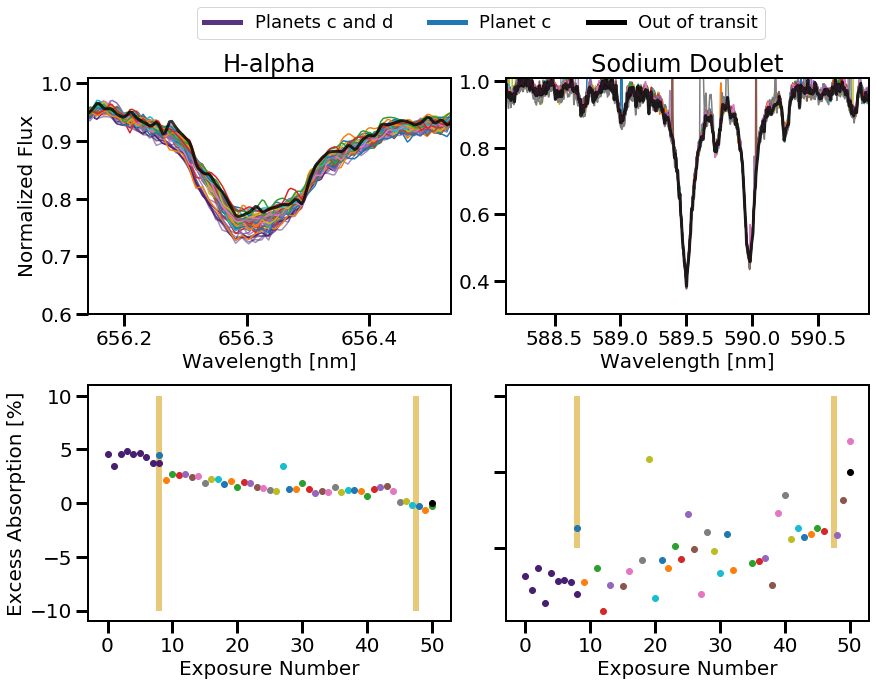

In [107]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(ncols=2, nrows=2,
                                           figsize=(14,10))

plot_transmissions(halpha_wavelength, halpha_order, SPECTRA, subregion_ha, ax=[ax1,ax3])
plot_transmissions(sodium_wavelength, sodium_order, SPECTRA, subregion_na, ax=[ax2,ax4], 
                   row=2,
                   feature='Sodium Doublet')

plt.subplots_adjust(hspace=0.3, wspace=0.15)

#plt.savefig('/Users/arcticfox/Desktop/line_absorption.pdf', 
#            dpi=250, rasterize=True, bbox_inches='tight')

In [116]:
both_transits  = SPECTRA[BIN1,9,:]
transit_c      = SPECTRA[BIN2,9,:]
out_of_transit = SPECTRA[BIN3,9,:]
template_out   = np.nanmedian(SPECTRA[BIN3,9,:], axis=0)

### To Do
- try with orders without any significant lines
- trends with time-dependent features (but not in h-alpha)
- figure out where in reduction we're inducing that (if we are)
    - things like airmass (looking through more atmosphere will change shape)
- Andreas has models of telluric spectra on Archipelago /data/maroonx_spectra_reduced
    - order by order in maroon x order

In [128]:
iron_order

20

(-0.5, 0.5)

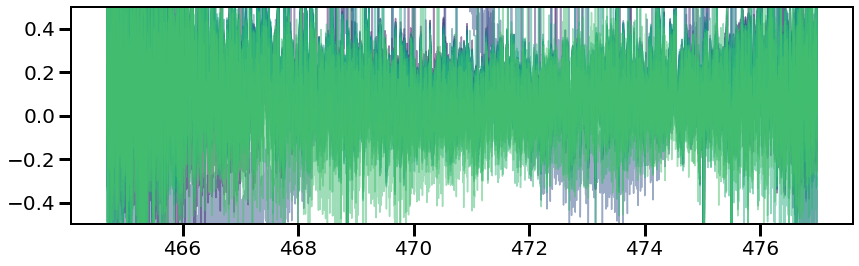

In [149]:
j = -1
both_transits  = SPECTRA[BIN1,j,:]
transit_c      = SPECTRA[BIN2,j,:]
out_of_transit = SPECTRA[BIN3,j,:]
template_out   = np.nanmedian(SPECTRA[BIN3,j,:], axis=0)

#for i in range(len(both_transits)):
#    plt.plot(both_transits[i]-template_out, 'r')
plt.figure(figsize=(14,4))
for i in range(len(transit_c)):
    plt.plot(WAVELENGTH[0][j], transit_c[i]-template_out, c=vcolors[i], alpha=0.5)
#for i in range(len(out_of_transit)):
#    plt.plot(out_of_transit[i]-template_out, 'g')
#plt.plot(template_out, 'k', linewidth=3)
plt.ylim(-0.5,0.5)

In [45]:
def plot_by_file(order, data, vline, save=False, output_fn=None):
    global WAVELENGTH, FILES, BIN3
    
    data = data[:,order]
    
    out_of_transit = np.nanmedian(data[BIN3], axis=0)
    
    colnum = 4
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=colnum, figsize=(14,10),
                                             sharex=True, sharey=True)
    offset = np.linspace(0,2,14)

    j = 0
    for i in range(len(SPECTRA[:-3])):
        if i <= 13:
            ax = ax1
        elif i>13 and i <=27:
            ax = ax2
        elif i>27 and i<=41:
            ax = ax3
        else:
            ax = ax4
        ax.plot(halpha_wavelength[0], data[i]/out_of_transit - offset[j], '.',
               ms=2, c=vcolors[i])
        j += 1
        if j > len(offset)-1:
            j = 0

    plt.xlim(vline-1, vline+1)
    plt.ylim(-1.1,1.1)

    ax1.set_ylabel('$F / F_{out}$ + offset', fontsize=25)
    ax2.set_xlabel('Wavelength [nm]', x=1, fontsize=25)

    ax1.vlines(vline, -10, 10, linewidth=15, alpha=0.35)
    ax2.vlines(vline, -10, 10, linewidth=15, alpha=0.35)
    ax3.vlines(vline, -10, 10, linewidth=15, alpha=0.35)
    ax4.vlines(vline, -10, 10, linewidth=15, alpha=0.35)

    ax1.axhspan(-0.33, 2, facecolor=colors[0])
    ax1.axhspan(-10, -0.33, facecolor=colors[10])
    ax2.axhspan(-10, 10, facecolor=colors[10])
    ax3.axhspan(-10, 10, facecolor=colors[10])
    ax4.axhspan(0.45, 10, facecolor=colors[10])
    ax4.axhspan(-10, 0.45, facecolor=colors[30])

    plt.subplots_adjust()
    
    if save is True:
        plt.savefig('/Users/arcticfox/Desktop/{}'.format(output_fn), 
                    dpi=250, rasterize=True,
                    bbox_inches='tight')

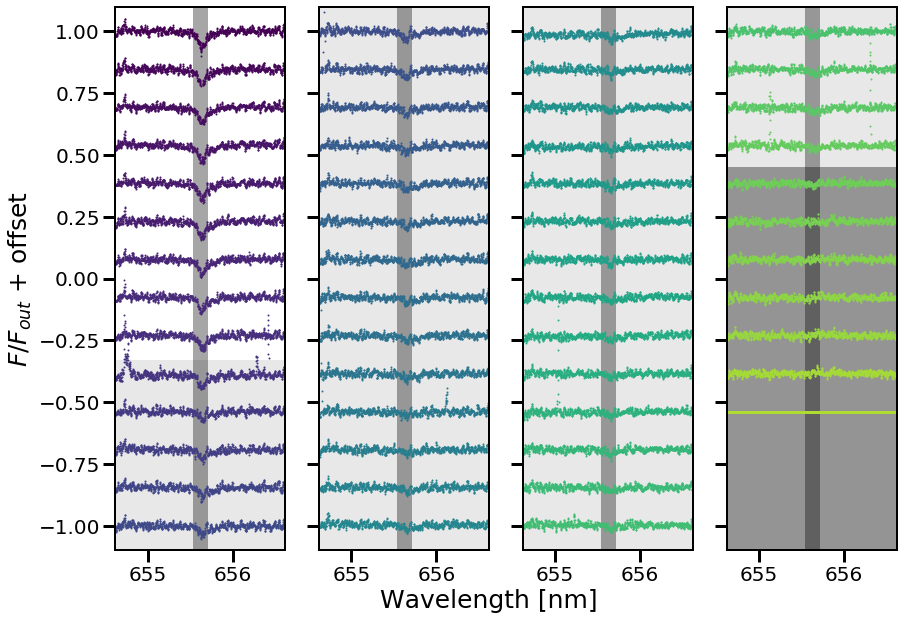

In [46]:
plot_by_file(halpha_order, SPECTRA, halpha_vline)